In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from itertools import product
from tqdm import tqdm_notebook
#from heuristi_plot_1 import plot as hplot

path = '../output_data/'

In [2]:
with pd.HDFStore(path + 'X1a1.h5') as store:
    data = store.select('dat_1', where='phi=0.5 & n_rn>15 & n_rn<32 & n_cp < 21', columns=['decision state', 'i_c', 'G'])
data.index = data.index.droplevel(['phi', 'test'])
data = data.reset_index('tstep')
data = data.reset_index().drop_duplicates(['n_rn', 'n_cp', 'sample', 'tstep']).set_index(['n_rn', 'n_cp', 'sample', 'tstep'])
data.index.levels

G_start = data[['G']].max()[0]

In [3]:
c1 = 0.43 # tons of co2 per barrel oil https://www.epa.gov/energy/greenhouse-gases-equivalencies-calculator-calculations-and-references
c2 = 7.33 # barrels per toe https://en.wikipedia.org/wiki/Tonne_of_oil_equivalent
c3 = 10e6 # tons per megaton

# carbon budgets from 2011 onwards
b15p66 = 400 # Giga tones of co2 https://www.carbontracker.org/carbon-budgets-explained/ and IPCC2013
b15p50 = 550
b15p33 = 850
b20p66 = 1000

x1 = b15p66/c1 # budged in giga tones CO2/CO2 emissions per barrel -> budget in billion barrels oil
x2 = x1/c2 # budget in billion barrels / barrels per toe -> budget in Gtoe
budget_mtoe = x2*10e3 # budget in Gtoe * 10^3 -> budget in Mtoe

# emissions per mtoe:
co2_per_toe = c1*c2 # tones of co2 per toe

data['emissions'] = (data[['G']].xs(level='tstep', key=1).max() - data[['G']])*co2_per_toe*10e-4 # emissions in Gtones CO2

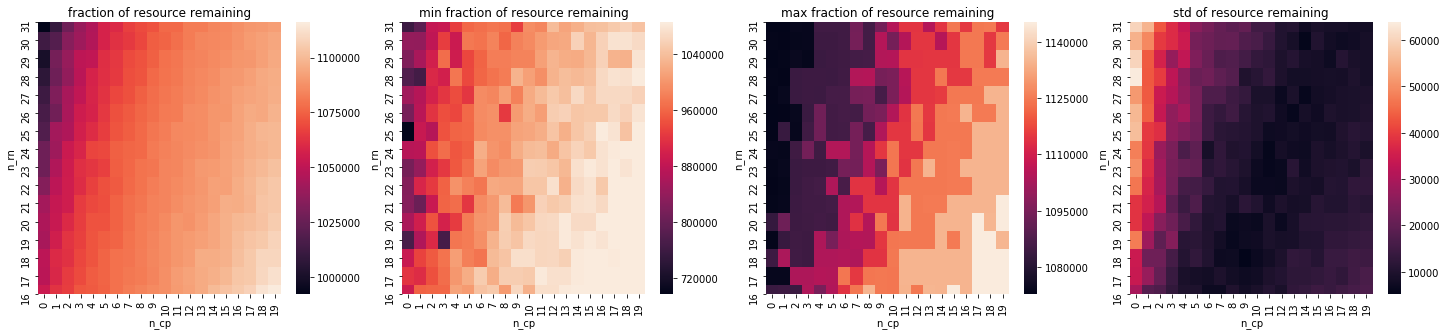

In [4]:
# fraction of resource remaining at success of campaign

# when 2/3 vote for clean investment

data[['Gm']] = data[['G']]#/G_start

data_tmp1 = data.loc[data['decision state']>.66][['Gm']].reset_index()

# for each pair of n_rn, n_cp and sample, select the row with smallest time (the one, where it tipped)
data_tmp2 = data_tmp1.loc[data_tmp1.groupby(['n_rn', 'n_cp', 'sample'])['tstep'].idxmin()]

# for that time, look at remaining resource and take the mean over it:
res1_mean = data_tmp2.set_index(['n_rn', 'n_cp', 'sample'])[['Gm']].unstack('sample').mean(axis=1).unstack('n_cp')
res1_std = data_tmp2.set_index(['n_rn', 'n_cp', 'sample'])[['Gm']].unstack('sample').std(axis=1).unstack('n_cp')

res1_min = data_tmp2.set_index(['n_rn', 'n_cp', 'sample'])[['Gm']].unstack('sample').min(axis=1).unstack('n_cp')
res1_max = data_tmp2.set_index(['n_rn', 'n_cp', 'sample'])[['Gm']].unstack('sample').max(axis=1).unstack('n_cp')

# and plot the fraction of remaining resource


fig, ax = plt.subplots(ncols=4, figsize=(25,5))

sn.heatmap(res1_mean, ax=ax[0])
sn.heatmap(res1_min, ax=ax[1])
sn.heatmap(res1_max, ax=ax[2])
sn.heatmap(res1_std, ax=ax[3])

for ax, text in zip(ax, ['fraction of', 'min fraction of', 'max fraction of', 'std of']):
    ax.invert_yaxis()
    txt = ax.set_title(f'{text} resource remaining')

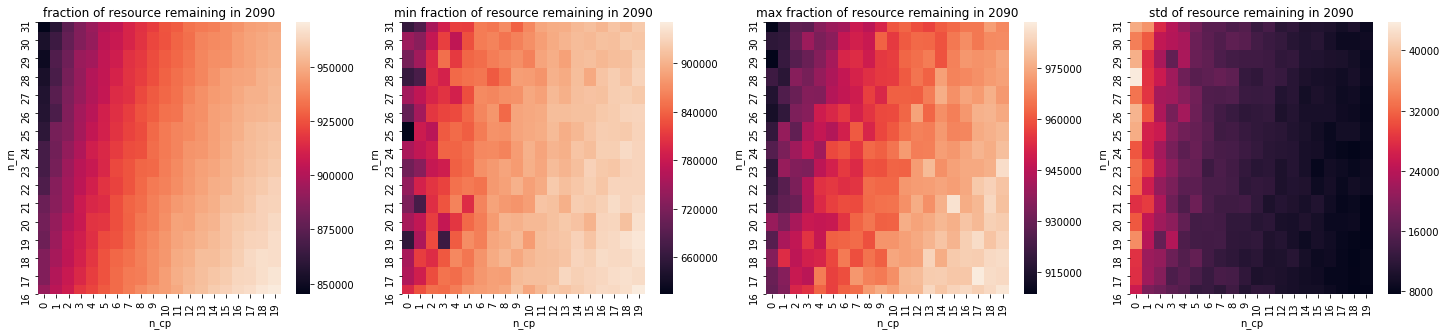

In [5]:
# fraction of resource remaining in 2050

data_tmp1 = data[['Gm']].xs(level='tstep', key=90).unstack('sample')

res2_mean = data_tmp1.mean(axis=1).unstack('n_cp')
res2_min = data_tmp1.min(axis=1).unstack('n_cp')
res2_max = data_tmp1.max(axis=1).unstack('n_cp')
res2_std = data_tmp1.std(axis=1).unstack('n_cp')

fig, ax = plt.subplots(ncols=4, figsize=(25,5))

sn.heatmap(res2_mean, ax=ax[0])
sn.heatmap(res2_min, ax=ax[1])
sn.heatmap(res2_max, ax=ax[2])
sn.heatmap(res2_std, ax=ax[3])

for ax, text in zip(ax, ['fraction of', 'min fraction of', 'max fraction of', 'std of']):
    ax.invert_yaxis()
    txt = ax.set_title(f'{text} resource remaining in 2090')

In [6]:
# probability of staying within the 1.5C, p=66% budget at the sucess of the campaign

target = b15p50

# when 2/3 vote for clean investment

data_tmp1 = data.loc[data['decision state']>.66][['emissions']].reset_index()

# for each pair of n_rn, n_cp and sample, select the row with smallest time (the one, where it tipped)
data_tmp2 = data_tmp1.loc[data_tmp1.groupby(['n_rn', 'n_cp', 'sample'])['tstep'].idxmin()]

# for that time, look at remaining resource and take the mean over it:
res1_mean = (data_tmp2.set_index(['n_rn', 'n_cp', 'sample'])[['emissions']]<target).unstack('sample').mean(axis=1).unstack('n_cp')
res1_std = (data_tmp2.set_index(['n_rn', 'n_cp', 'sample'])[['emissions']]<target).unstack('sample').sem(axis=1).unstack('n_cp')

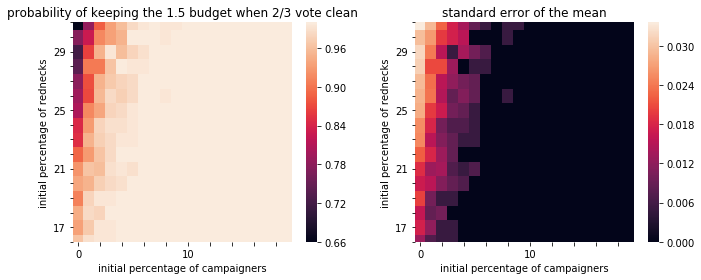

In [7]:
# and plot the fraction of remaining resource

fig1, ax1 = plt.subplots(ncols=2, figsize=(10,4))

sn.heatmap(res1_mean, ax=ax1[0])
sn.heatmap(res1_std, ax=ax1[1])

ax1[0].set_title('probability of keeping the 1.5 budget when 2/3 vote clean')
ax1[1].set_title('standard error of the mean')
for axis in ax1:
    axis.invert_yaxis()
    axis.set_xlabel('initial percentage of campaigners')
    axis.set_ylabel('initial percentage of rednecks')
    axis.tick_params(axis='both', rotation=0)
    #axis.locator_params(axis='both', nbins=5)
    every_nth = 5
    for n, label in enumerate(axis.xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)
    every_nth = 4
    for n, label in enumerate(axis.yaxis.get_ticklabels()):
        if (n - 1) % every_nth != 0:
            label.set_visible(False)
fig1.tight_layout()
fig1.savefig('p_budget15p66_at_campaign_success.pdf')

In [8]:
# probability of staying within the 1.5C, p=66% budget at year 2010 + t_max

# when 2/3 vote for clean investment

t_max = 40
target = b15p50

data_tmp1 = data.xs(level='tstep', key=t_max)[['emissions']].reset_index()

# for that time, look at remaining resource and take the mean over it:
res2_mean = (data_tmp1.set_index(['n_rn', 'n_cp', 'sample'])[['emissions']]<target).unstack('sample').mean(axis=1).unstack('n_cp')
res2_std = (data_tmp1.set_index(['n_rn', 'n_cp', 'sample'])[['emissions']]<target).unstack('sample').sem(axis=1).unstack('n_cp')

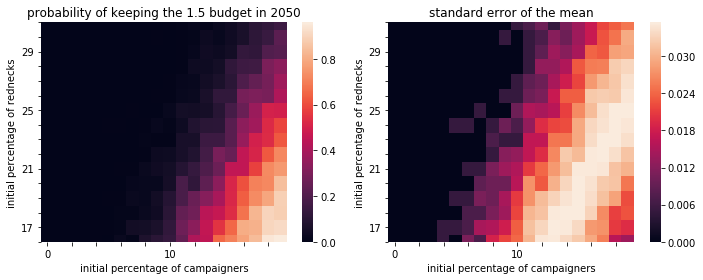

In [9]:
# and plot the fraction of remaining resource

fig2, ax2 = plt.subplots(ncols=2, figsize=(10,4))

sn.heatmap(res2_mean, ax=ax2[0])
sn.heatmap(res2_std, ax=ax2[1])

ax2[0].set_title(f'probability of keeping the 1.5 budget in {2010+t_max}')
ax2[1].set_title('standard error of the mean')
for axis in ax2:
    axis.invert_yaxis()
    axis.set_xlabel('initial percentage of campaigners')
    axis.set_ylabel('initial percentage of rednecks')
    axis.tick_params(axis='both', rotation=0)
    #axis.locator_params(axis='both', nbins=5)
    every_nth = 5
    for n, label in enumerate(axis.xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)
    every_nth = 4
    for n, label in enumerate(axis.yaxis.get_ticklabels()):
        if (n - 1) % every_nth != 0:
            label.set_visible(False)
fig2.tight_layout()
fig2.savefig('p_budget15p50_in2050.pdf')

(0, 1)

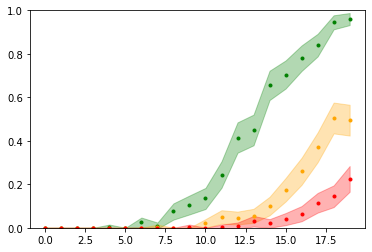

In [10]:
fig, ax = plt.subplots()

rednecks = [16, 25, 30]
colors = ['green', 'orange', 'red']

for c, rn in zip(colors, rednecks):

    df = res2_mean.stack('n_cp').xs(level='n_rn', key=rn)
    df_s = 2*res2_std.stack('n_cp').xs(level='n_rn', key=rn)
    x = df.index.values
    y = df.values
    dy = df_s.values

    ax.plot(x, y, '.', color=c)
    ax.fill_between(x, y+dy, y-dy, alpha=.3, color=c)

ax.set_ylim([0,1])

In [11]:
# Time until emission targets is reached.

# when 2/3 vote for clean investment

data[['Gm']] = data[['G']]

data_tmp1 = data.loc[data['emissions']>b15p50].reset_index()

data_tmp2 = data_tmp1.loc[data_tmp1.groupby(['n_rn', 'n_cp', 'sample'])['tstep'].idxmin()].set_index(['n_rn', 'n_cp', 'sample'])[['tstep']]

res3_mean = data_tmp2.unstack('sample').mean(axis=1).unstack('n_cp')
res3_std = data_tmp2.unstack('sample').std(axis=1).unstack('n_cp')
res3_mean

n_cp,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
n_rn,,,,,,,,,,,,,,,,,,,,
16,22.265,22.990,23.665,25.190,25.875,26.815,28.175,29.515000,31.994975,32.974747,34.793970,36.724490,40.902564,42.212766,44.977011,49.710059,53.601266,54.227586,56.517241,57.132653
17,21.880,22.845,23.655,24.265,25.630,26.565,28.285,29.683417,30.190000,31.850000,33.900000,37.413265,39.744898,43.010471,44.595745,45.937853,52.257310,51.262195,53.887324,55.793651
18,21.925,22.620,23.285,24.085,25.060,26.850,28.025,28.590000,29.875000,31.275000,33.135678,36.753769,37.828283,42.192513,41.979058,44.395722,46.637427,52.359756,56.294118,54.235669
19,21.675,22.265,23.195,23.980,24.780,26.150,26.535,27.950000,29.465000,31.215000,33.255000,35.085859,37.233503,38.355330,40.622449,43.196809,46.955556,49.526012,49.574850,53.782895
20,21.625,22.200,23.090,23.600,24.955,24.905,26.290,27.720000,29.235000,30.090000,31.760000,34.969388,34.331658,37.632653,38.937500,43.187166,45.994624,47.817680,49.224138,51.312102
21,21.340,22.010,22.490,23.695,24.205,24.815,26.265,27.715000,28.560000,30.250000,31.590000,33.065000,34.585859,36.340000,38.297980,41.565445,41.386243,45.539267,48.459770,51.624309
22,20.965,21.930,22.465,23.160,23.990,25.095,25.725,26.775000,28.200000,29.420000,30.295000,31.995000,33.040201,34.848485,37.736041,37.868020,41.577320,42.905263,46.616216,48.765714
23,20.790,21.795,22.380,23.070,23.530,24.420,25.915,26.815000,28.015000,28.170000,29.835000,31.160000,32.788945,35.030303,35.945000,37.306533,39.270408,42.181347,44.697917,47.005319
24,20.870,21.440,22.135,22.850,23.915,24.620,25.640,26.385000,26.590000,28.565000,29.625000,30.477387,32.555000,33.045000,34.376884,36.409091,39.437186,40.346939,43.246231,44.388601


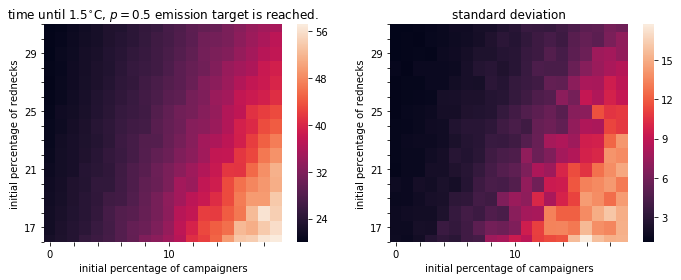

In [12]:
fig3, ax3 = plt.subplots(ncols=2, figsize=(10,4))

sn.heatmap(res3_mean, ax=ax3[0])
sn.heatmap(res3_std, ax=ax3[1])

for axis, text in zip(ax3, ['fraction of', 'min fraction of', 'max fraction of', 'std of']):
    axis.invert_yaxis()
    axis.set_xlabel('initial percentage of campaigners')
    axis.set_ylabel('initial percentage of rednecks')
    axis.tick_params(axis='both', rotation=0)
    #axis.locator_params(axis='both', nbins=5)
    every_nth = 5
    for n, label in enumerate(axis.xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)
    every_nth = 4
    for n, label in enumerate(axis.yaxis.get_ticklabels()):
        if (n - 1) % every_nth != 0:
            label.set_visible(False)
txt = ax3[0].set_title('time until $1.5^{\circ}$C, $p=0.5$ emission target is reached.')
txt = ax3[1].set_title(f'standard deviation')
fig3.tight_layout()
fig3.savefig('time_until_emissions_target.pdf')

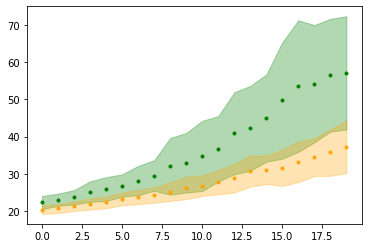

In [13]:
fig, ax = plt.subplots()

rednecks = [16, 30]
colors = ['green', 'orange', 'red']

for c, rn in zip(colors, rednecks):

    df = res3_mean.stack('n_cp').xs(level='n_rn', key=rn)
    df_s = res3_std.stack('n_cp').xs(level='n_rn', key=rn)
    x = df.index.values
    y = df.values
    dy = df_s.values

    ax.plot(x, y, '.', color=c)
    ax.fill_between(x, y+dy, y-dy, alpha=.3, color=c)

#ax.set_ylim([0,1])

In [14]:
data

decision state       i_c             G   emissions  \
n_rn n_cp sample tstep                                                       
18   0    0      0.0          0.000000  0.484213  1.155583e+06  -32.858351   
                 1.0          0.137682  0.138105  1.145004e+06    0.486424   
                 2.0          0.148817  0.149031  1.134454e+06   33.739791   
                 3.0          0.165000  0.165057  1.123938e+06   66.884260   
                 4.0          0.155000  0.154880  1.113462e+06   99.903554   
                 5.0          0.155000  0.154770  1.103026e+06  132.795665   
                 6.0          0.170000  0.169739  1.092628e+06  165.571257   
                 7.0          0.210000  0.209807  1.082271e+06  198.213674   
                 8.0          0.220000  0.219914  1.071981e+06  230.649156   
                 9.0          0.860000  0.860070  1.061935e+06  262.310801   
                 10.0         0.844545  0.844848  1.052375e+06  292.444424   
                 11.0         0.830000  0.830711  1.043284e+06  321.096724   
                 12.0         0.845000  0.845966  1.034647e+06  348.320710   
                 13.0         0.860000  0.861322  1.026463e+06  374.117334   
                 14.0         0.870000  0.871896  1.018725e+06  398.505078   
                 15.0         0.905000  0.906934  1.011434e+06  421.486178   
                 16.0         0.915000  0.917190  1.004593e+06  443.049075   
                 17.0         0.910000  0.912882  9.981876e+05  463.237153   
                 18.0         0.920000  0.922825  9.921973e+05  482.118195   
                 19.0         0.915000  0.917723  9.866027e+05  499.751766   
                 20.0         0.910000  0.913313  9.813761e+05  516.225566   
                 21.0         0.930000  0.933075  9.764926e+05  531.617625   
                 22.0         0.930000  0.933945  9.719388e+05  545.970978   
                 23.0         0.940000  0.943621  9.676989e+05  559.334525   
                 24.0         0.940000  0.943920  9.637541e+05  571.768330   
                 25.0         0.940000  0.944680  9.600820e+05  583.342290   
                 26.0         0.950000  0.953417  9.566629e+05  594.118935   
                 27.0         0.950000  0.953864  9.534820e+05  604.144834   
                 28.0         0.955000  0.958693  9.505233e+05  613.470246   
                 29.0         0.955000  0.959084  9.477713e+05  622.144392   
...                                ...       ...           ...         ...   
31   15   141    71.0         1.000000  1.000000  9.389012e+05  650.102135   
                 72.0         0.990000  0.989984  9.387491e+05  650.581350   
                 73.0         0.995000  0.995044  9.386038e+05  651.039341   
                 74.0         0.995000  0.995110  9.384653e+05  651.476010   
                 75.0         0.990000  0.990055  9.383324e+05  651.894875   
                 76.0         0.985000  0.985185  9.382035e+05  652.301175   
                 77.0         0.990000  0.990235  9.380778e+05  652.697430   
                 78.0         0.992827  0.993108  9.379557e+05  653.082309   
                 79.0         0.990000  0.990356  9.378377e+05  653.454036   
                 80.0         0.985000  0.985507  9.377231e+05  653.815173   
                 81.0         0.990000  0.990286  9.376103e+05  654.170844   
                 82.0         0.990000  0.990416  9.374998e+05  654.519184   
                 83.0         0.985000  0.985592  9.373916e+05  654.860060   
                 84.0         0.980000  0.980792  9.372843e+05  655.198373   
                 85.0         0.975000  0.976047  9.371764e+05  655.538310   
                 86.0         0.985000  0.985893  9.370675e+05  655.881653   
                 87.0         0.990000  0.990833  9.369605e+05  656.218913   
                 88.0         0.990000  0.990926  9.368567e+05  656.546195   
                 89.0         0.990000  0.9910